In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression # Added LinearRegression for comparison
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("Karachi_Property_Dataset.csv")
df.head()

,Price,ID,Address,Bathrooms,Bedrooms,Size/Area,Purpose,Type,Real State Agency,Real State Agent Name
0,PKR7.9 Crore,34881234,"DHA Phase 6, DHA Defence, Karachi, Sindh",4,5,300 Sq. Yd.,For Sale,House,Bukhari Properties,Bukhari Properties Builders
1,PKR1.88 Crore,38292537,"Bahria Town - Precinct 11-A, Bahria Town - Pre...",3,3,150 Sq. Yd.,For Sale,House,Rohan Real Estate,Gul Ahmed
2,PKR2.3 Crore,37292645,"Bahria Town - Precinct 10-A, Bahria Town Karac...",3,3,200 Sq. Yd.,For Sale,House,Z & A Real Estate & Builders,Asim Khaliq
3,PKR12.99 Crore,38291342,"DHA Phase 5, DHA Defence, Karachi, Sindh",6,6,500 Sq. Yd.,For Sale,House,Safeway Estate & Builders,Sikandar Minhas Zubair Khan
4,PKR95 Lakh,37930847,"Bahria Greens, Bahria Town Karachi, Karachi, S...",3,3,75 Sq. Yd.,For Sale,House,Al Waiz Group,Aamir Shahzad Waiz


In [3]:
def convert_price(x):
    if pd.isna(x) or str(x).strip().lower() in ["na", "nan", "none", ""]:
        return np.nan
    x = str(x).replace("PKR", "").strip()
    if "Crore" in x:
        return float(x.split()[0]) * 10_000_000
    elif "Lakh" in x:
        return float(x.split()[0]) * 100_000
    else:
        return float(x.split()[0])

In [4]:
df["Price"] = df["Price"].apply(convert_price)
df["Size"] = pd.to_numeric(df["Size/Area"].str.split(" ", expand=True)[0], errors="coerce")
df["Bedrooms"] = pd.to_numeric(df["Bedrooms"], errors="coerce")
df["Bathrooms"] = pd.to_numeric(df["Bathrooms"], errors="coerce")

In [5]:
temp_df = df["Address"].str.split(",", expand=True)
df["Neighborhood"] = temp_df[0].str.strip() + " " + temp_df[1].str.strip().fillna("")

In [6]:
df.dropna(subset=["Price", "Size", "Bedrooms"], inplace=True)
df = df[df["Price"] > 100000] 
df = df[df["Size"] > 10]

In [7]:
df.drop(columns=["ID","Address","Size/Area","Purpose","Type","Real State Agency","Real State Agent Name"],inplace=True)

In [8]:
low, high = df["Price"].quantile([0.1, 0.9])
df = df[df["Price"].between(low, high)]

In [9]:
features = ["Size", "Neighborhood", "Bedrooms", "Bathrooms"]
target = "Price"
X = df[features]
y = df[target]

In [10]:
y_mean = y.mean()
y_pred_baseline = [y_mean] * len(y)
print("Baseline MAE:", mean_absolute_error(y, y_pred_baseline))

Baseline MAE: 13727637.77480401


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model_ridge = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown="ignore"), 
    SimpleImputer(strategy="mean"),
    StandardScaler(), 
    Ridge()
)

In [13]:
model_ridge.fit(X_train, y_train)

C:\Users\mujta\anaconda3\Lib\site-packages\sklearn\externals\_numpydoc\docscrape.py:420: UserWarning: Unknown section Example
  self[section] = content


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,['Neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'ignore'
,use_cat_names,True


In [14]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown="ignore"), 
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    LinearRegression()
)

In [15]:
model_lr.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,['Neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'ignore'
,use_cat_names,True


In [16]:
print("Ridge Test MAE:", mean_absolute_error(y_test, model_ridge.predict(X_test)))
print("Linear Regression Test MAE:", mean_absolute_error(y_test, model_lr.predict(X_test)))

Ridge Test MAE: 1968920.8221311911
Linear Regression Test MAE: 1968899.903959945


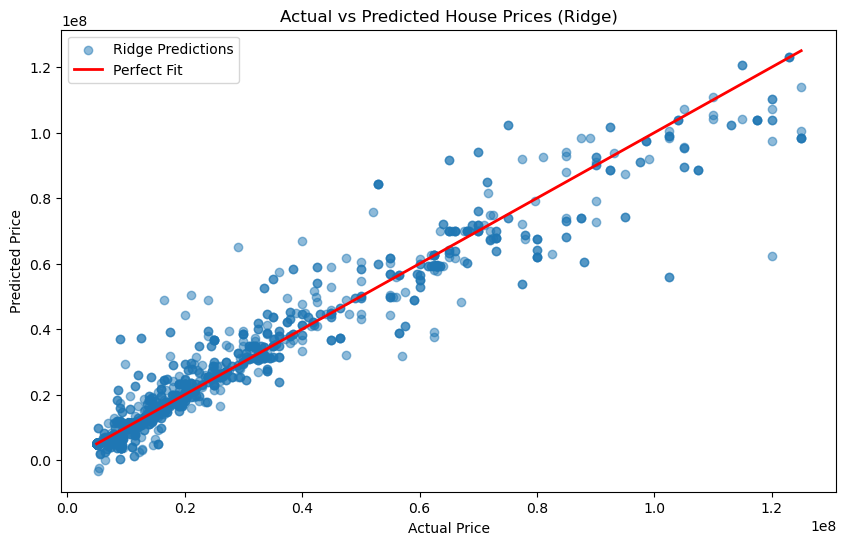

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model_ridge.predict(X_test), alpha=0.5, label="Ridge Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label="Perfect Fit")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices (Ridge)")
plt.legend()
plt.show()

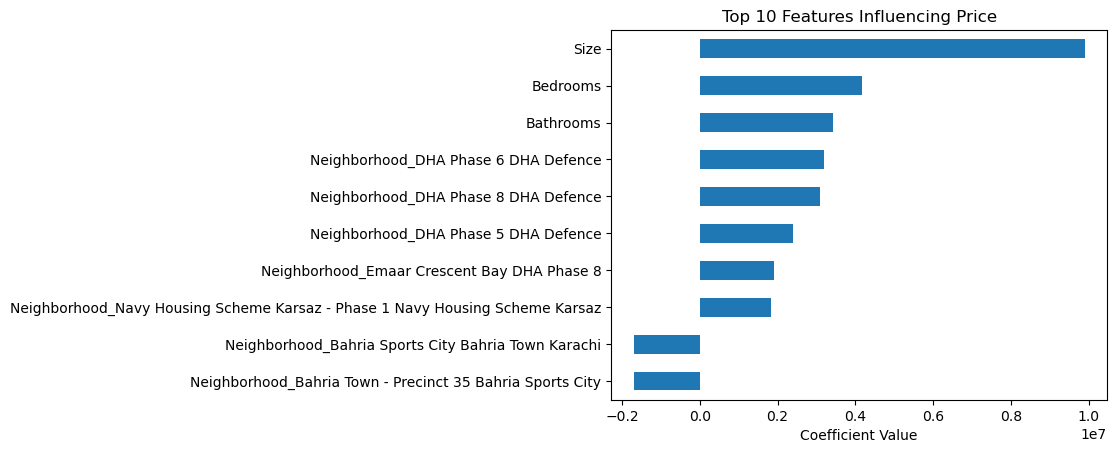

In [18]:
coefficients = model_ridge.named_steps['ridge'].coef_
features_names = model_ridge.named_steps['onehotencoder'].get_feature_names_out()
feat_imp = pd.Series(coefficients, index=features_names).sort_values(key=abs).tail(10)
feat_imp.plot(kind='barh')
plt.title("Top 10 Features Influencing Price")
plt.xlabel("Coefficient Value")
plt.show()